In [1]:
import uproot
import numpy as np
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import itertools
import awkward as ak
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

In [2]:
file = uproot.open("tracking_losses_ntuple_Bd2KstEE.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1")

#selektiere nur elektronen von B->K*ee und nur solche mit einem momentum von ueber 5 GeV 
allcolumns = file.arrays()
found = allcolumns[(allcolumns.isElectron) & (~allcolumns.lost) & (allcolumns.fromSignal) & (allcolumns.p > 5e3)] #B: 9056
lost = allcolumns[(allcolumns.isElectron) & (allcolumns.lost) & (allcolumns.fromSignal) & (allcolumns.p > 5e3)] #B: 1466

ak.num(found, axis=0)
#ak.count(found, axis=None)

9056

In [3]:
def t_eff(found, lost, axis = 0):
    sel = ak.num(found, axis=axis)
    des = ak.num(lost, axis=axis)
    return sel/(sel + des)

t_eff(found, lost)

0.8606728758791105

In [19]:
#finden wir die elektronen die keine bremsstrahlung gemacht haben mit hoher effizienz?
#von energie der photonen abmachen
#scan ab welcher energie der photonen die effizienz abfällt

#abhängigkeit vom ort der emission untersuchen   <- noch nicht gemacht



#idea: we make an event cut st all events that contain a photon of energy > cutoff_energy are not included
"""
ph_e = found["brem_photons_pe"]
event_cut = ak.all(ph_e<cutoff_energy,axis=1)
ph_e = ph_e[event_cut]
"""




for cutoff_energy in range(0,550,100):
	nobrem_f = found[ak.all(found["brem_photons_pe"]<cutoff_energy,axis=1)]
	nobrem_l = lost[ak.all(lost["brem_photons_pe"]<cutoff_energy,axis=1)]
	print("sample size: ",ak.num(nobrem_f,axis=0)+ak.num(nobrem_l,axis=0))
	print("eff (cutoff = ",str(cutoff_energy),") = ",str(t_eff(nobrem_f,nobrem_l)))

"""
we see that a cutoff energy of 350MeV is ideal because the efficiency drops significantly for higher values
"""
cutoff_energy = 350.0 #MeV

"""
better statistics: cutoff=350MeV - sample size: 150 events and efficiency=0.9533
"""
nobrem_found = found[ak.all(found["brem_photons_pe"]<cutoff_energy,axis=1)]
nobrem_lost = lost[ak.all(lost["brem_photons_pe"]<cutoff_energy,axis=1)]

print("cutoff energy = 350MeV\nsample size:",ak.num(nobrem_found,axis=0)+ak.num(nobrem_lost,axis=0))
print("eff = ",t_eff(nobrem_found, nobrem_lost))

sample size:  32
eff (cutoff =  0 ) =  0.96875
sample size:  32
eff (cutoff =  100 ) =  0.96875
sample size:  65
eff (cutoff =  200 ) =  0.9692307692307692
sample size:  129
eff (cutoff =  300 ) =  0.9457364341085271
sample size:  169
eff (cutoff =  400 ) =  0.9408284023668639
sample size:  227
eff (cutoff =  500 ) =  0.920704845814978
cutoff energy = 350MeV
sample size: 150
eff =  0.9533333333333334


In [5]:
#wie viel energie relativ zur anfangsenergie verlieren die elektronen durch bremstrahlung und hat das einen einfluss darauf ob wir sie finden oder nicht?
#if any photon of an electron has an energy higher the cutoff then it is included
cutoff_energy=350

brem_found = found[ak.any(found["brem_photons_pe"]>=cutoff_energy,axis=1)]
energy_found = ak.to_numpy(brem_found["energy"])
eph_found = ak.to_numpy(ak.sum(brem_found["brem_photons_pe"], axis=-1, keepdims=False))
energyloss_found = eph_found/energy_found

brem_lost = lost[ak.any(lost["brem_photons_pe"]>=cutoff_energy,axis=1)]
energy_lost = ak.to_numpy(brem_lost["energy"])
eph_lost = ak.to_numpy(ak.sum(brem_lost["brem_photons_pe"], axis=-1, keepdims=False))
energyloss_lost = eph_lost/energy_lost

t_eff(brem_found,brem_lost)

0.8593328191284226

In [6]:
mean_energyloss_found = ak.mean(energyloss_found)
mean_energyloss_lost = ak.mean(energyloss_lost)
print("mean energyloss relative to initial energy (found): ", mean_energyloss_found)
print("mean energyloss relative to initial energy (lost): ", mean_energyloss_lost)

mean energyloss relative to initial energy (found):  0.6551043170507098
mean energyloss relative to initial energy (lost):  0.8273131179948844


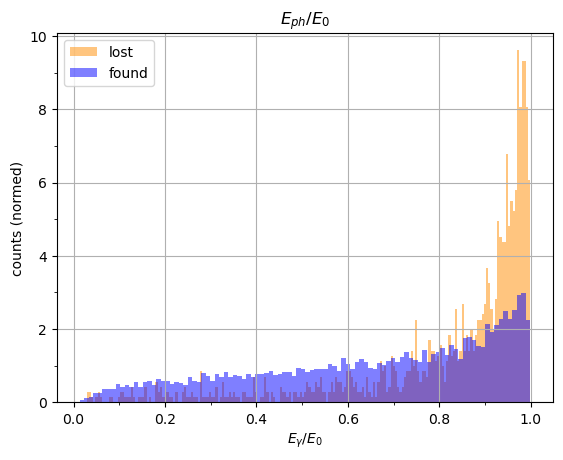

In [7]:
#in abhängigkeit von der energie der elektronen
plt.hist(energyloss_lost, bins=200, density=True, alpha=0.5, histtype='bar', color="darkorange", label="lost")
plt.hist(energyloss_found, bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label="found")
plt.xticks(np.arange(0,1.1,0.1), minor=True,)
plt.yticks(np.arange(0,10,1), minor=True)
plt.xlabel(r"$E_\gamma/E_0$")
plt.ylabel("counts (normed)")
plt.title(r'$E_{ph}/E_0$')
plt.legend()
plt.grid()

"""

"""

plt.show()

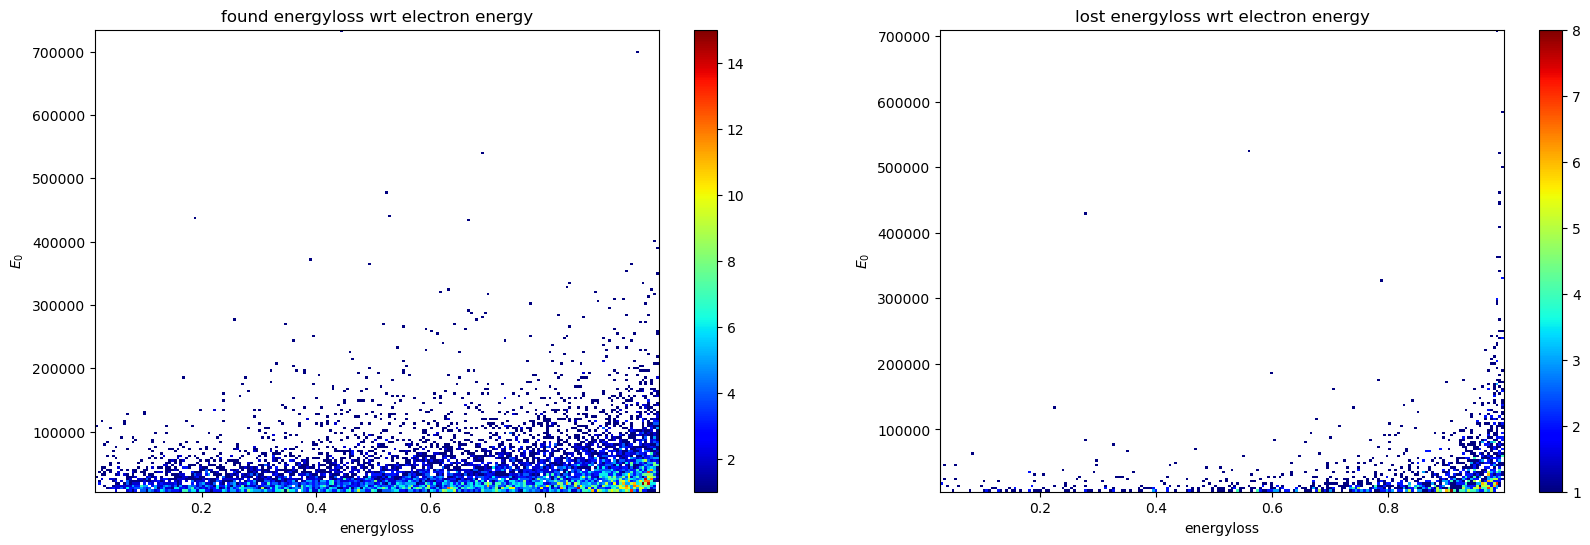

In [8]:
#energyloss in abh von der energie der elektronen
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

a0=ax0.hist2d(energyloss_found, energy_found, bins=200, cmap=plt.cm.jet, cmin=1)
ax0.set_xlabel("energyloss")
ax0.set_ylabel(r"$E_0$")
ax0.set_title("found energyloss wrt electron energy")
plt.colorbar(a0[3],ax=ax0)

a1=ax1.hist2d(energyloss_lost, energy_lost, bins=200, cmap=plt.cm.jet, cmin=1) 
ax1.set_xlabel("energyloss")
ax1.set_ylabel(r"$E_0$")
ax1.set_title("lost energyloss wrt electron energy")
plt.colorbar(a1[3],ax=ax1)

"""
"""
plt.show()

In [9]:
#ist die shape der teilspur im scifi anders? (koenntest du zum beispiel durch vergleich der verteilungen der fit parameter studieren,
#in meiner thesis findest du das fitmodell -- ist einfach ein polynom dritten grades)
z_ref=8520 #mm

def scifi_track(z, a, b, c, d):
    return a + b*(z-z_ref) + c*(z-z_ref)**2 + d*(z-z_ref)**3

def z_mag(xv, zv, tx, a, b):
    """ optical centre of the magnet is defined as the intersection between the trajectory tangents before and after the magnet

    Args:
        xv (double): velo x track
        zv (double): velo z track
        tx (double): velo x slope
        a (double): ax parameter of track fit
        b (double): bx parameter of track fit

    Returns:
        double: z_mag
    """
    return (xv-tx*zv-a+b*z_ref)/(b-tx)

In [10]:
scifi_found = found[found["scifi_hit_pos_x_length"]>3]
scifi_lost = lost[lost["scifi_hit_pos_x_length"]>3]
#should be fulfilled by all candidates

scifi_x_found = scifi_found["scifi_hit_pos_x"]
scifi_z_found = scifi_found["scifi_hit_pos_z"]

tx_found = scifi_found["velo_track_tx"]

scifi_x_lost = scifi_lost["scifi_hit_pos_x"]
scifi_z_lost = scifi_lost["scifi_hit_pos_z"]

tx_lost = scifi_lost["velo_track_tx"]

xv_found = scifi_found["velo_track_x"]
zv_found = scifi_found["velo_track_z"]

xv_lost = scifi_lost["velo_track_x"]
zv_lost = scifi_lost["velo_track_z"]



sf_energy_found = ak.to_numpy(scifi_found["energy"])
sf_eph_found = ak.to_numpy(ak.sum(scifi_found["brem_photons_pe"], axis=-1, keepdims=False))
sf_vtx_type_found = scifi_found["all_endvtx_types"]


brem_vtx_type_found = scifi_found[scifi_found["endvtx_type"]==101]

sf_energy_lost = ak.to_numpy(scifi_lost["energy"])
sf_eph_lost = ak.to_numpy(ak.sum(scifi_lost["brem_photons_pe"], axis=-1, keepdims=False))
sf_vtx_type_lost = scifi_lost["all_endvtx_types"]
brem_vtx_type_lost = scifi_lost[scifi_lost["endvtx_type"]==101]



#ak.num(scifi_found["energy"], axis=0)
#scifi_found.snapshot()

In [11]:
ak.num(scifi_found["energy"], axis=0)
scifi_found["all_endvtx_types"][1,:]

<Array [101, 101, 101, 101, 101, ..., 101, 101, 101, 0] type='11 * float32'>

In [12]:
scifi_fitpars_found = ak.ArrayBuilder()
vtx_types_found = ak.ArrayBuilder()

for i in range(0,ak.num(scifi_found, axis=0)):
    popt, pcov = curve_fit(scifi_track,ak.to_numpy(scifi_z_found[i,:]),ak.to_numpy(scifi_x_found[i,:]))
    scifi_fitpars_found.begin_list()
    scifi_fitpars_found.real(popt[0])
    scifi_fitpars_found.real(popt[1])
    scifi_fitpars_found.real(popt[2])
    scifi_fitpars_found.real(popt[3])
    #[:,4] -> energy 
    scifi_fitpars_found.real(sf_energy_found[i])
    #[:,5] -> photon energy
    scifi_fitpars_found.real(sf_eph_found[i])
    scifi_fitpars_found.end_list()
    
    vtx_types_found.begin_list()
    #[:,0] -> endvtx_type
    vtx_types_found.extend(sf_vtx_type_found[i,:])
    vtx_types_found.end_list()
    

scifi_fitpars_lost = ak.ArrayBuilder()
vtx_types_lost = ak.ArrayBuilder()

for i in range(0,ak.num(scifi_lost, axis=0)):
    popt, pcov = curve_fit(scifi_track,ak.to_numpy(scifi_z_lost[i,:]),ak.to_numpy(scifi_x_lost[i,:]))
    scifi_fitpars_lost.begin_list()
    scifi_fitpars_lost.real(popt[0])
    scifi_fitpars_lost.real(popt[1])
    scifi_fitpars_lost.real(popt[2])
    scifi_fitpars_lost.real(popt[3])
    #[:,4] -> energy 
    scifi_fitpars_lost.real(sf_energy_lost[i])
    #[:,5] -> photon energy
    scifi_fitpars_lost.real(sf_eph_lost[i])
    scifi_fitpars_lost.end_list()
    
    vtx_types_lost.begin_list()
    #[:,6] -> endvtx_type
    vtx_types_lost.extend(sf_vtx_type_lost[i,:])
    vtx_types_lost.end_list()
    


scifi_fitpars_lost = ak.to_numpy(scifi_fitpars_lost)
scifi_fitpars_found = ak.to_numpy(scifi_fitpars_found)

vtx_types_lost = ak.Array(vtx_types_lost)
vtx_types_found = ak.Array(vtx_types_found)



In [13]:
vtx_types_found[0]

<Array [101, 101, 101, 101, 101, ..., 101, 101, 101, 0] type='11 * float64'>

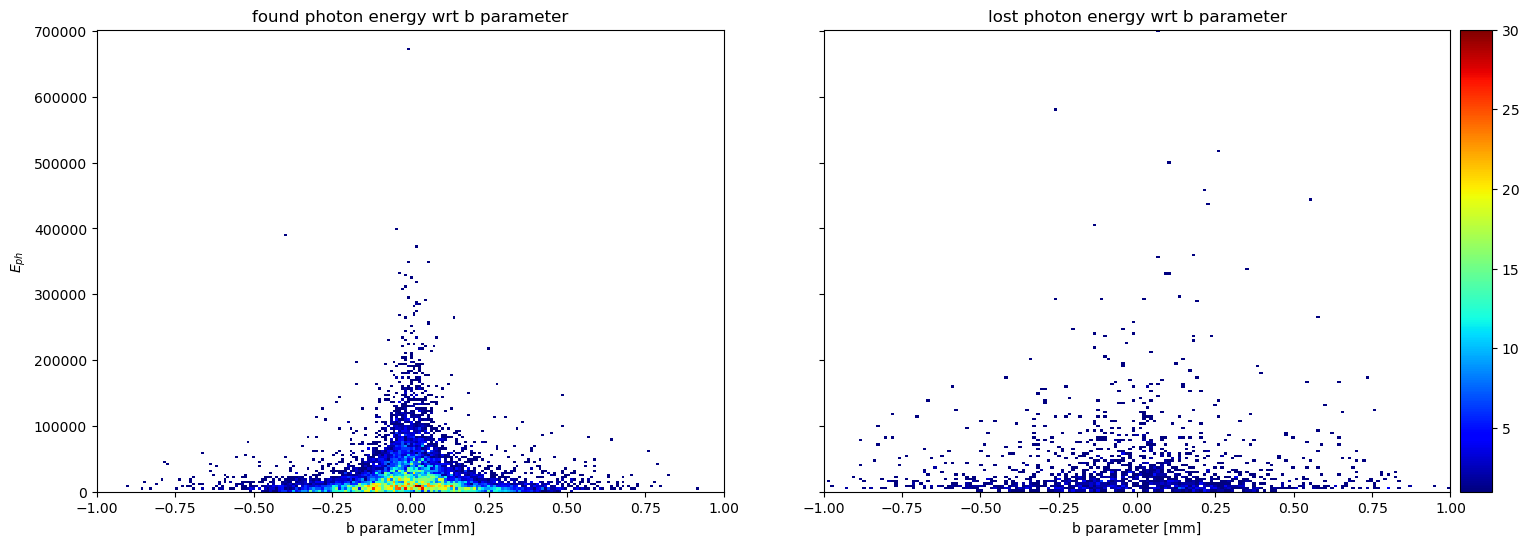

In [14]:
#b parameter des fits [:,1] hat für lost eine breitere Verteilung. Warum?
#evtl multiple scattering candidates (lost); findet man einen gewissen endvtx_type (mult scattering)
#steiler velo winkel (eta)? vertex type? evtl bremsstrahlung?

#isolate b parameters for analysis
b_found = scifi_fitpars_found[:,1]
b_lost = scifi_fitpars_lost[:,1]

brem_energy_found = scifi_fitpars_found[:,5]
brem_energy_lost = scifi_fitpars_lost[:,5]


bs_found, vtx_types_found = ak.broadcast_arrays(b_found, vtx_types_found)
bs_found = ak.to_numpy(ak.ravel(bs_found))
vtx_types_found = ak.to_numpy(ak.ravel(vtx_types_found))

bs_lost, vtx_types_lost = ak.broadcast_arrays(b_lost, vtx_types_lost)
bs_lost = ak.to_numpy(ak.ravel(bs_lost))
vtx_types_lost = ak.to_numpy(ak.ravel(vtx_types_lost))




#Erste Annahme ist Bremsstrahlung

fig = plt.figure(figsize=(18,6))
axes = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=1,  # pad between axes in inch.
                 cbar_mode="single",
                 cbar_location="right",
                 cbar_pad=0.1,
                 aspect=False
                )


h0 = axes[0].hist2d(b_found, brem_energy_found, bins=200, cmap=plt.cm.jet, cmin=1,vmax=30)
axes[0].set_xlim(-1,1)
axes[0].set_xlabel("b parameter [mm]")
axes[0].set_ylabel(r"$E_{ph}$")
axes[0].set_title("found photon energy wrt b parameter")

h1 = axes[1].hist2d(b_lost, brem_energy_lost, bins=200, cmap=plt.cm.jet, cmin=1,vmax=30)
axes[1].set_xlim(-1,1)
axes[1].set_xlabel("b parameter [mm]")
axes[1].set_ylabel(r"$E_{ph}$")
axes[1].set_title("lost photon energy wrt b parameter")

fig.colorbar(h0[3], cax=axes.cbar_axes[0], orientation='vertical')

"""
"""

plt.show()

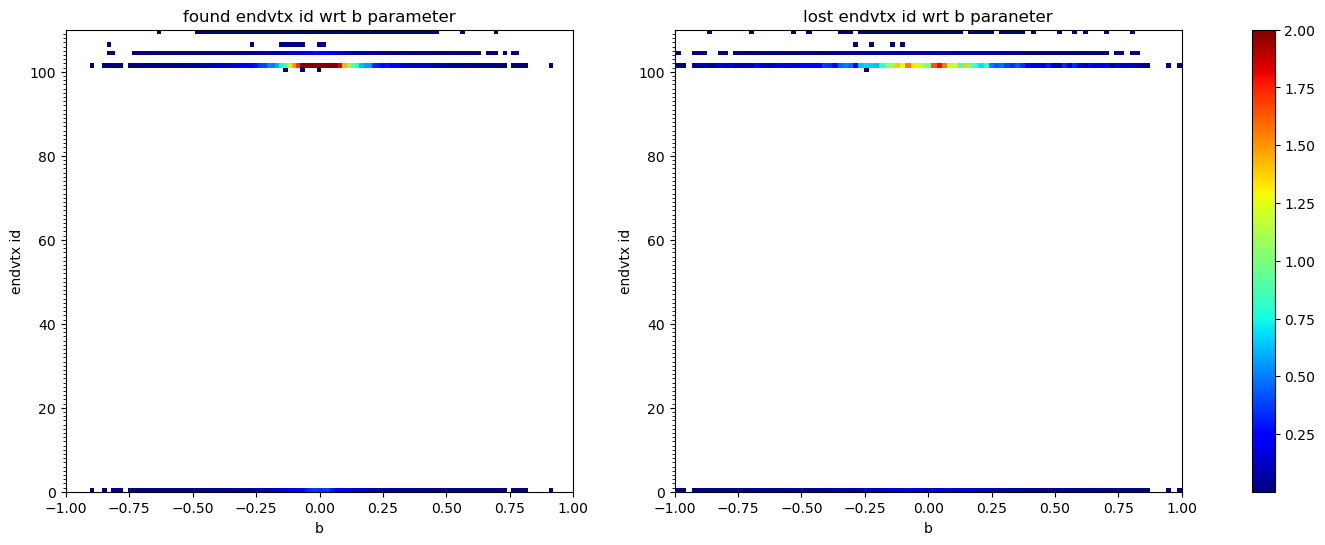

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

a0=ax[0].hist2d(bs_found, vtx_types_found, bins=110, density=True, cmap=plt.cm.jet, cmin=1e-20,vmax=2)
ax[0].set_ylim(0,110)
ax[0].set_xlim(-1,1)
ax[0].set_xlabel("b")
ax[0].set_ylabel("endvtx id")
ax[0].set_title("found endvtx id wrt b parameter")
ax[0].set_yticks(np.arange(0,110,1),minor=True)

a1=ax[1].hist2d(bs_lost, vtx_types_lost, bins=110, density=True, cmap=plt.cm.jet, cmin=1e-20,vmax=2)
ax[1].set_ylim(0,110)
ax[1].set_xlim(-1,1)
ax[1].set_xlabel("b")
ax[1].set_ylabel("endvtx id")
ax[1].set_title("lost endvtx id wrt b paraneter")
ax[1].set_yticks(np.arange(0,110,1), minor=True)

"""
vtx_id: 101 - Bremsstrahlung
B:
wir können nicht wirklich sagen dass bei den lost teilchen jegliche endvertex types überwiegen, im gegensatz zu den found 
"""
fig.colorbar(a0[3], ax=ax, orientation='vertical')
plt.show()

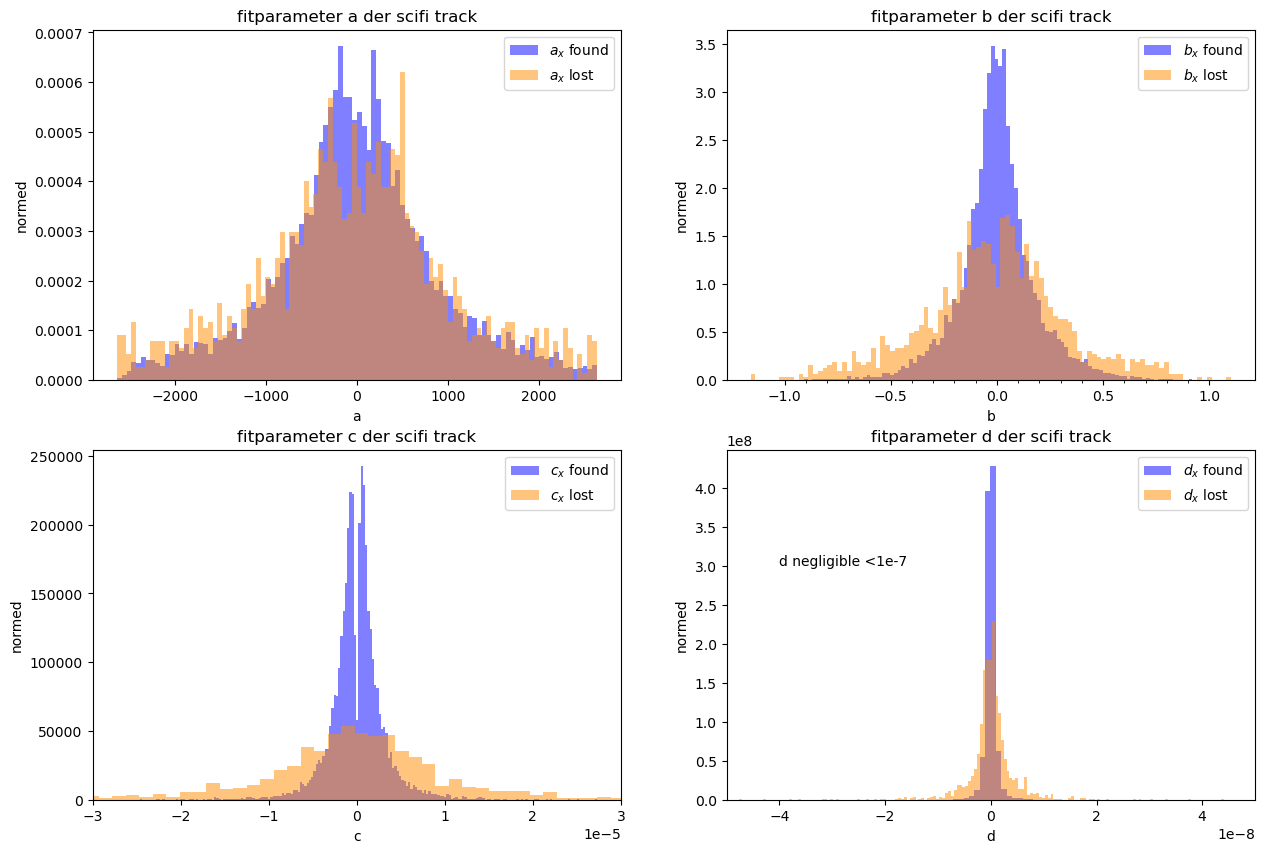

In [16]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

ax0.hist(scifi_fitpars_found[:,0], bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$a_x$ found")
ax0.hist(scifi_fitpars_lost[:,0], bins=100, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$a_x$ lost")
ax0.set_xlabel("a")
ax0.set_ylabel("normed")
ax0.set_title("fitparameter a der scifi track")
ax0.legend()

ax1.hist(scifi_fitpars_found[:,1], bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$b_x$ found")
ax1.hist(scifi_fitpars_lost[:,1], bins=100, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$b_x$ lost")
ax1.set_xticks(np.arange(-1,1,0.1),minor=True)
ax1.set_xlabel("b")
ax1.set_ylabel("normed")
ax1.set_title("fitparameter b der scifi track")
ax1.legend()
#evtl multiple scattering candidates (lost); findet man einen gewissen endvtx_type (mult scattering)
#steiler velo winkel (eta)? vertex type? evtl bremsstrahlung?


ax2.hist(scifi_fitpars_found[:,2], bins=500, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$c_x$ found")
ax2.hist(scifi_fitpars_lost[:,2], bins=500, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$c_x$ lost")
ax2.set_xlim([-3e-5,3e-5])
ax2.set_xticks(np.arange(-3e-5,3.5e-5,1e-5),minor=False)
ax2.set_xlabel("c")
ax2.set_ylabel("normed")
ax2.set_title("fitparameter c der scifi track")
ax2.legend()

ax3.hist(scifi_fitpars_found[:,3], bins=500, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$d_x$ found")
ax3.hist(scifi_fitpars_lost[:,3], bins=500, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$d_x$ lost")
ax3.set(xlim=(-5e-8,5e-8))
ax3.text(-4e-8,3e8,"d negligible <1e-7")
ax3.set_xlabel("d")
ax3.set_ylabel("normed")
ax3.set_title("fitparameter d der scifi track")
ax3.legend()

"""
a_x: virtual hit on the reference plane
"""

plt.show()